In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.neighbors import KDTree

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 50

import src

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
train_models = src.shapenet.get_shapenet_data("val")
ppfnet = src.pointnet.PPFNet()
ppfnet.model.load_weights("models/test3")

In [3]:
nb_points = 100000
nb_patches=2048
nb_points_per_patches = 1024

#path = np.random.choice(train_models)
path = 'data/ShapeNetCore.v2/02691156/973211dfe6bcc4ae90b1d6deb98feec6/models/model_normalized.obj'
cloud = src.shapenet.sample_points(path , nb=nb_points)
extractor = src.dataset.PPFPatchExtractor(nb_patches=nb_patches, nb_points=nb_points_per_patches)
centers, centers_normals, patches, patches_normals, centers_idx = extractor.make_patches(cloud)
ppf = extractor.compute_ppf(centers, centers_normals, patches, patches_normals).astype(np.float32)
M = extractor.compute_M(centers)

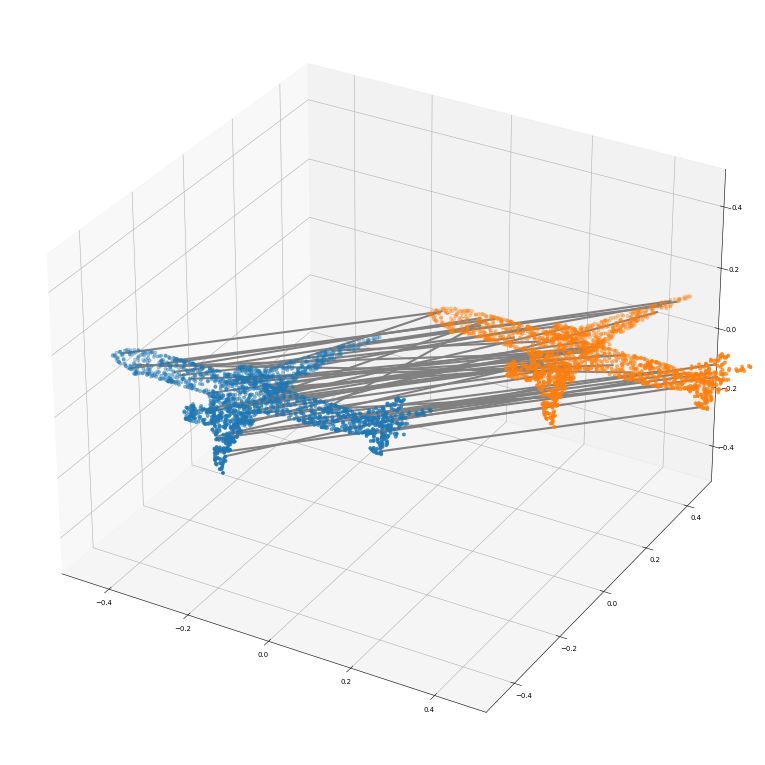

In [4]:
pred = ppfnet.model(ppf[np.newaxis])
diff = pred[:,:,tf.newaxis] - pred[:,tf.newaxis] # (N, nb_patches, nb_patches, features)
D = tf.reduce_sum(diff*diff, axis=-1) # (N, nb_patches, nb_patches)

matches = np.argsort(D[0].numpy(), axis=0)[1]

nb_matches = 50
centers_idx_np = centers_idx
idx_start = np.arange(nb_matches)
idx_start = centers_idx_np[idx_start]
idx_end = matches[:nb_matches]
idx_end = centers_idx_np[idx_end]


cloud_np = cloud[0]
pos_start = cloud_np[idx_start]
pos_end = cloud_np[idx_end]
delta = np.array([0.25, 0,0.25])
curves = np.stack([pos_start - delta, pos_end + delta], axis=1)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

n= 2000
xs = cloud_np[:n,2]
ys = cloud_np[:n,0]
zs = cloud_np[:n,1]

lim = (-0.5,0.5)

ax.set_xlim(lim)
ax.set_ylim(lim) 
ax.set_zlim(lim) 

ax.scatter(xs-0.25, ys-0.25, zs)
ax.scatter(xs+0.25, ys+0.25, zs)
for i in range(nb_matches):
    ax.plot(curves[:,:,2][i], curves[:,:,0][i], curves[:,:,1][i],linewidth=3, color="grey")

plt.show()

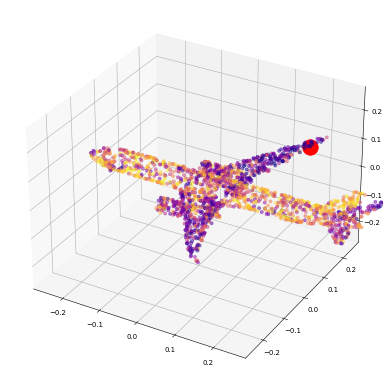

In [19]:
pred = ppfnet.model(ppf[np.newaxis])
diff = pred[0,:,tf.newaxis] - pred[0,tf.newaxis] # (N, nb_patches, nb_patches, features)
D = tf.reduce_sum(diff*diff, axis=-1) # (N, nb_patches, nb_patches)

patch_idx = np.random.randint(len(ppf))

cloud_pos = cloud[0]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

#Point cloud of the model

xs = centers[:,2]
ys = centers[:,0]
zs = centers[:,1]

lim = (-0.27,0.27)

ax.set_xlim(lim)
ax.set_ylim(lim) 
ax.set_zlim(lim) 

cmap = plt.get_cmap("plasma")
colors = cmap(np.linspace(0,1,len(centers))[np.argsort(np.argsort(D[patch_idx]))])

ax.scatter(xs, ys, zs, alpha=0.5, color=colors)
src.utils.export_ply("output/similarity.ply", centers, normals=centers_normals, scalar=D[patch_idx])
src.utils.export_ply("output/patche.ply", patches[patch_idx])

#Center of chosen patch

xs = centers[patch_idx,2]
ys = centers[patch_idx,0]
zs = centers[patch_idx,1]

ax.scatter(xs, ys, zs, color="red", s=500)
plt.show()

In [28]:
#patch_idx = np.random.randint(len(ppf))
patch_idx = np.argmin(centers[:,1])

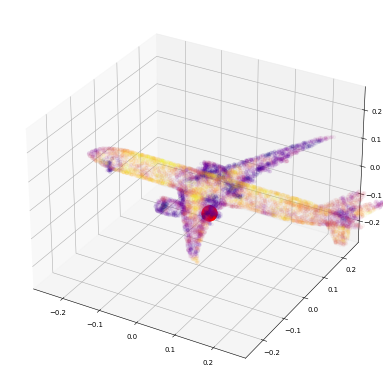

In [29]:
pred = ppfnet.model(ppf[np.newaxis])
diff = pred[0,:,tf.newaxis] - pred[0,tf.newaxis] # (N, nb_patches, nb_patches, features)
D = tf.reduce_sum(diff*diff, axis=-1) # (N, nb_patches, nb_patches)

cloud_pos = cloud[0]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

#Point cloud of the model

kdt = KDTree(centers)
neighbors = kdt.query(cloud_pos, k=3, return_distance=False)
values = D[patch_idx].numpy()[neighbors].mean(axis=-1)

src.utils.export_ply("output/similarity.ply", cloud_pos, normals=cloud[1], scalar=np.max(values) - values)
src.utils.export_ply("output/patche.ply", patches[patch_idx])

n_points = 10000
values = values[:n_points]
xs = cloud_pos[:n_points,2]
ys = cloud_pos[:n_points,0]
zs = cloud_pos[:n_points,1]

lim = (-0.27,0.27)

ax.set_xlim(lim)
ax.set_ylim(lim) 
ax.set_zlim(lim) 


cmap = plt.get_cmap("plasma")
colors = cmap(np.linspace(0,1,n_points)[np.argsort(np.argsort(values))])
ax.scatter(xs, ys, zs, alpha=0.05, color=colors)

#Center of chosen patch

xs = centers[patch_idx,2]
ys = centers[patch_idx,0]
zs = centers[patch_idx,1]

ax.scatter(xs, ys, zs, color="red", s=500)
plt.show()